# Only need to execute this notebook in kaggle 
We trained the model, generated the prediction, then saved the output as submission.csv for scoring

In [2]:
import numpy as np
import pandas as pd
import cv2
import torchvision.transforms as transforms
import time
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import gc # aarbage collector to clean uesless data from memory

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# have checked that we can appropriately ignore warnings
import warnings
warnings.filterwarnings('ignore') # ignore warnings

### Set up the array generating function for later usage

In [3]:
# for test set only
# declare our image dimensions using color images

img_size = 250
channels = 3  # change to 1 if need to use grayscale image

# define function to read and process the images to an acceptable format for our model
def read_and_process_image_test(list_of_images):
    X = [] # an array of resized images
    for i, image in enumerate(list_of_images):
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (img_size, img_size), interpolation=cv2.INTER_CUBIC)) # read in the image

    return X

# Load in the training array and label
We have to up load them to the input section of kaggle notebook first, so we can load the preprocessed training set array:   
1. image size = 250 pixel * 250 pixels  
2. The categorical label has already been preprocessed using one hot encoding

In [4]:
X_TRAIN = np.load("/kaggle/input/training250/training_X.npy", allow_pickle = True)
y_TRAIN = pd.read_csv("/kaggle/input/categorical-score-no-metadata/with_category_score.csv")

print("shape of train images:", X_TRAIN.shape)
print("shape of labels:", y_TRAIN.shape)

shape of train images: (9912, 250, 250, 3)
shape of labels: (9912, 100)


In [5]:
# split the data into train and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_TRAIN, y_TRAIN, test_size=0.20, random_state=42)

print("shape of train images:", X_train.shape)
print("shape of validation images:", X_val.shape)
print("shape of labels:", y_train.shape)
print("shape of labels:", y_val.shape)

shape of train images: (7929, 250, 250, 3)
shape of validation images: (1983, 250, 250, 3)
shape of labels: (7929, 100)
shape of labels: (1983, 100)


In [5]:
# set up small batch to avoid run out of memory when allocating
batch_size = 32

In [6]:
# clear useless variables to save memory
del X_TRAIN
del y_TRAIN
gc.collect()

4

# Image augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# this would helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale = 1./255,   # scale the image between 0 and 1
                                   rotation_range = 60,
                                   width_shift_range = 1.0,
                                   height_shift_range = 1.0,
                                   shear_range = 0.4,
                                   zoom_range = [0.1, 2],
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)  # do not augment validation data. we only perform rescale

# create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

# Import modules for model training

In [17]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Self-built CNN  
(already be demonstrated in the regression version so skip here)

# Pretrained Keras model: EfficientNetB4 (version for classification)
### Among all the model we've tried (listed in the appendix), this model gave us the best result in test set
Since the submission of the notebook can't connect to the internet, we can't use the code like:  
"  pretrained_model = EfficientNetB4(include_top = False, weights = 'imagenet', input_shape=(img_size, img_size, 3)) "  
since this will need to connect to ImageNet to load the weight  

In [10]:
model_name = "efficientnetv2-b4"
model_handle_map = {'efficientnetv2-b4': '/kaggle/input/efficientnet/tensorflow2/b4-classification/1'}
model_image_size_map = {"efficientnetv2-b4": img_size}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, img_size)

print(f"selected model path: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print('input size:', IMAGE_SIZE)

selected model path: efficientnetv2-b4 : /kaggle/input/efficientnet/tensorflow2/b4-classification/1
input size (250, 250)


### (The units and droupout rate is randomly assigned to the layers)

In [11]:
import tensorflow_hub as hub

model = tf.keras.Sequential([
    # explicitly define the input shape: (250, 250, 3)
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    
    # set trainable = True for fine tune
    hub.KerasLayer(model_handle, trainable = True),
    
    # pooling and flaten layers are skipped in this version of pretrained model loading structure
    
    # dense layer 1
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 2
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 3
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 4
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 5
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 6
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("leaky_relu"),
    tf.keras.layers.Dropout(0.5),
    
    # dense layer 7
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("leaky_relu"),
    tf.keras.layers.Dropout(0.6),
    
    # dense layer 8
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("leaky_relu"),
    tf.keras.layers.Dropout(0.7),
    
    # dense layer 9
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("leaky_relu"),
    tf.keras.layers.Dropout(0.25),
    
    # dense layer 10
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("leaky_relu"),
    tf.keras.layers.Dropout(0.25),
    
    # dense layer 6, output layer
    tf.keras.layers.Dense(units=100, activation='softmax') # we view the 100 Pawpularity score as 100 categories
])
model.build((None,)+IMAGE_SIZE+(3,))

# check the model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              19466816  
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [12]:
# compile the model, using 'categorical_crossentropy' as loss function
# since this version is dealing with classification problem in multi outcomes
model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=[keras.metrics.CategoricalCrossentropy()])

In [13]:
# define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

### In the model training phase, we only extract epochs from 8-30 and set early stop to avoid overfitting  
We did this by setting initial_epoch to get more stable outcome

In [14]:
# train the model
model.fit(train_generator, 
          steps_per_epoch = len(X_train) // batch_size, 
          epochs=30, 
          initial_epoch = 7,
          validation_data=val_generator, 
          validation_steps = len(X_val) // batch_size,
          callbacks=[early_stopping])

Epoch 8/30
247/247 [==============================] - 312s 582ms/step - loss: 4.8170 - categorical_crossentropy: 4.5373 - val_loss: 4.6187 - val_categorical_crossentropy: 4.3359
Epoch 9/30
247/247 [==============================] - 140s 567ms/step - loss: 4.6332 - categorical_crossentropy: 4.3491 - val_loss: 4.4987 - val_categorical_crossentropy: 4.2134
Epoch 10/30
247/247 [==============================] - 141s 570ms/step - loss: 4.5680 - categorical_crossentropy: 4.2817 - val_loss: 4.4888 - val_categorical_crossentropy: 4.2017
Epoch 11/30
247/247 [==============================] - 141s 571ms/step - loss: 4.5461 - categorical_crossentropy: 4.2588 - val_loss: 4.4888 - val_categorical_crossentropy: 4.2014
Epoch 12/30
247/247 [==============================] - 141s 571ms/step - loss: 4.5316 - categorical_crossentropy: 4.2436 - val_loss: 4.4867 - val_categorical_crossentropy: 4.1991
Epoch 13/30
247/247 [==============================] - 141s 571ms/step - loss: 4.5162 - categorical_crossen

### Save the model for future useage

In [15]:
# save the entire model as a `.keras` zip archive
model.save('/kaggle/working/1204_efficientnetv2-b4_8-30_epochs_early_stop_classification.keras')

### Visualize training and validation loss

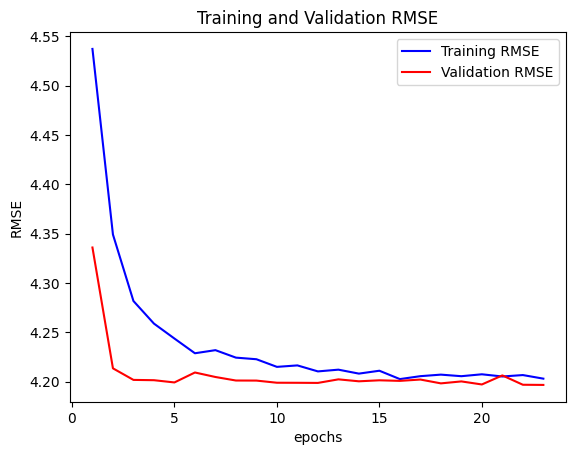

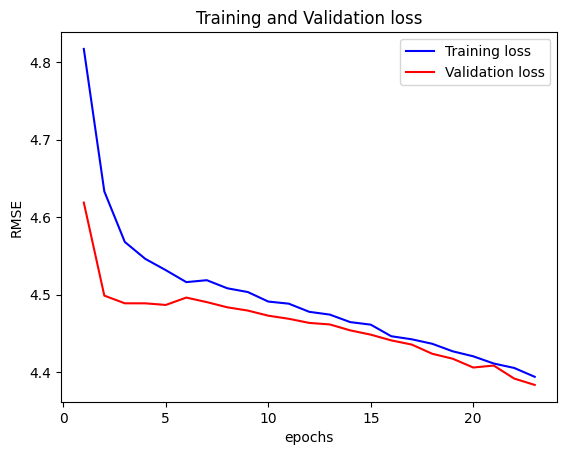

In [16]:
# plot the train and val curve

rmse = history.history['categorical_crossentropy']
val_rmse = history.history['val_categorical_crossentropy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(rmse) + 1)

#Train and validation accuracy
plt.plot(epochs, rmse, 'b', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r', label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

### Summary for model training
Loss in training set and validation set decreased gradually in the similar patterns as training epochs increase, and it wasn't interrupted by early stopping.  

# Do prediciton on testing set

In [ ]:
# load the model for next time
reloaded_model = tf.keras.models.load_model('/kaggle/working/1204_efficientnetv2-b4_8-30_epochs_early_stop_classification.keras')

### Read in testing images

In [15]:
test_dir = '/kaggle/input/petfinder-pawpularity-score/test'
test_imgs = ['/kaggle/input/petfinder-pawpularity-score/test/{}'.format(i) for i in os.listdir(test_dir)] # get test images

In [18]:
# process the test set
X_test = read_and_process_image_test(test_imgs) 

# convert list to numpy array
X_test = np.array(X_test)

# augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test) # after rescaling for the colors

### Set up Id for DataFrame building

In [19]:
Id = []

for i in range(len(test_imgs)):
    id = test_imgs[i].split('test/')[1].split('.')[0]
    Id.append(id)

In [20]:
Id

['c978013571258ed6d4637f6e8cc9d6a3',
 '4e429cead1848a298432a0acad014c9d',
 '43a2262d7738e3d420d453815151079e',
 '8f49844c382931444e68dffbe20228f4',
 '4128bae22183829d2b5fea10effdb0c3',
 '80bc3ccafcc51b66303c2c263aa38486',
 'e0de453c1bffc20c22b072b34b54e50f',
 'b03f7041962238a7c9d6537e22f9b017']

### Predict on test set

In [22]:
outcome = reloaded_model.predict(test_generator)

1/1 [==============================] - 3s 3s/step


### There're 8 images in test set, and for each image we generated the probability for it to be scored as 1 to 100

In [40]:
len(outcome) # we only have 8 images in test set

8

In [42]:
len(outcome[0]) # and for each image, we generate the probability for it to be scored as 1 to 100, thus having length = 100

100

### Construct the Pawpularity array to record the scores

In [43]:
Pawpularity = []

for i in range(len(test_imgs)):
    pawpularity = 0
    for j in range(100):
        pawpularity = pawpularity + outcome[i][j]*(j+1)
    Pawpularity.append(pawpularity)

In [44]:
Pawpularity

[38.141670293029165,
 38.141670293029165,
 38.1416702727729,
 38.141670293029165,
 38.1416702727729,
 38.1416702727729,
 38.141670293029165,
 38.1416702727729]

# Metadata
We also combined the metadata to see if the performance could be improved  

We regress Pawpularity scores on features in the table to train an SVR model then do prediction on test set,  
then we combine these scores with the Pawpularity scores generated from CNN by taking average

In [8]:
df = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv')
df = df.drop(columns = 'Id')

X_train_SVR = df.iloc[:, 0:12]
y_train_SVR = df.iloc[:, 12]

from sklearn.model_selection import train_test_split
X_train_svr, X_val_svr, y_train_svr, y_val_svr = train_test_split(X_train_SVR, y_train_SVR, test_size=0.2, random_state=42)

### (This part was done in another notebook)

In [ ]:
'''svr_grid = {'kernel': ['rbf'], 'C': [10, 1, 0.1], 'epsilon': [10, 1, 0.1], 'gamma': [10, 1, 0.1, 0.01]}
svr = svm.SVR() # for svr, y is expected to have floating point values instead of integer values

svr_clf = GridSearchCV(estimator = svr, param_grid = svr_grid, scoring = 'neg_root_mean_squared_error', cv = 10, refit = True)    
svr_clf.fit(X_train_svr, y_train_svr)
print("Best hyperparameters settings: ", svr_clf.best_params_)
print('RMSE: ', -svr_clf.best_score_)'''

### From the GridSearch in advance, we got the optimozed hyperparameters
To save time for final auto-grading in the system, we did the GridSearch in advance in another notebook (attached in appendix)  

And we got the following optimized hyperparameters:  
{'C': 0.1, 'epsilon': 10, 'gamma': 1, 'kernel': 'rbf'}  
RMSE:  20.644052638806244

In [9]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

svr_clf = svm.SVR(C = 0.1, epsilon = 10, gamma = 1, kernel = 'rbf') # for svr, y is expected to have floating point values instead of integer values
svr_clf.fit(X_train_svr, y_train_svr)

SVR(C=0.1, epsilon=10, gamma=1)

In [10]:
df_test = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/test.csv')
df_test = df_test.drop(columns = 'Id')

# extract independent variables
X_test_svr = df_test.iloc[:, 0:12]

# generate prediction
y_pred = svr_clf.predict(X_test_svr)
y_pred

array([35.56403228, 35.89369024, 35.52965552, 35.4705902 , 35.51811519,
       35.5632086 , 35.52966413, 35.38661314])

# Take mean of the 2 scores generated to get the final Pawpularity scores

In [13]:
score = (y_pred + Pawpularity)/2
score

array([36.85285129, 37.01768026, 36.8356629 , 36.80613025, 36.82989273,
       36.85243943, 36.83566721, 36.76414171])

### Now let's build the dataframe to save as a csv file

In [21]:
dic = {'Id': Id, 'Pawpularity': score}
result = pd.DataFrame(dic)
result.head(10)

,Id,Pawpularity
0,c978013571258ed6d4637f6e8cc9d6a3,36.852851
1,4e429cead1848a298432a0acad014c9d,37.017680
2,43a2262d7738e3d420d453815151079e,36.835663
3,8f49844c382931444e68dffbe20228f4,36.806130
4,4128bae22183829d2b5fea10effdb0c3,36.829893
5,80bc3ccafcc51b66303c2c263aa38486,36.852439
6,e0de453c1bffc20c22b072b34b54e50f,36.835667
7,b03f7041962238a7c9d6537e22f9b017,36.764142


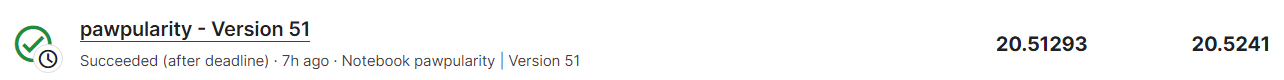

### The grade we get in the end, already much better than other models we've tried

In [22]:
# save the DataFrame to a CSV file for submission
result.to_csv('submission.csv', index=False)

# This is the end of the notebook